In [ ]:
# #@title Download Kaggle API token from Google Drive
# import gdown
# import os
# from pathlib import Path

# gdrive_url = 'https://drive.google.com/uc?id=1P6t7O8vOjmQi3rMX0KQlgO6BT0fk2dI-'
# if not os.path.exists('kaggle.json'):
#   gdown.download(gdrive_url, 'kaggle.json', quiet=False)

# kaggle_dir = Path.home() / '.kaggle'
# kaggle_token_path = kaggle_dir / 'kaggle.json'

# if not kaggle_token_path.exists():
#   kaggle_dir.mkdir(parents=True, exist_ok=True)
#   os.rename('kaggle.json', kaggle_token_path)
#   kaggle_token_path.chmod(0o600)

# dataset_path = 'global_covid-19'
# if not os.path.exists(dataset_path):
#   os.mkdir(dataset_path)
#   !kaggle datasets download -d rohitashchandra/global-covid19-twitter-dataset --path {dataset_path} --unzip
#   gdrive_url = 'https://drive.google.com/uc?id=19Hr0PQSyqGqLLJlPaDKjMfvlbFVnYbBr'
#   os.remove(os.path.join(dataset_path, 'India.csv'))
#   gdown.download(gdrive_url, os.path.join(dataset_path, 'India.csv'), quiet=False)

In [3]:
from csv import QUOTE_NONE
import os
import pandas as pd
import random
import csv
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from geopy.geocoders import Nominatim
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#@title merge into one csv

# List to hold the dataframes
dataframes = []
dataset = ['Australia.csv', 'Brazil.csv', 'India.csv', 'Indonesia.csv', 'Japan.csv']
# Read each CSV file with specific settings to handle quoting issues
for data in dataset:
  try:
    # Open the file with utf-8 encoding, handle errors by replacing problematic characters
    with open(data, 'r', encoding='utf-8', newline='') as file:
      df = pd.read_csv(file, on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL)
      df = df.iloc[:, 1:]
  except UnicodeDecodeError:
    # Fallback to a different encoding if UTF-8 doesn't work
    with open(data, 'r', encoding='ISO-8859-1', newline='') as file:
      df = pd.read_csv(file, on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL)
      df = df.iloc[:, 1:]
  dataframes.append(df)
  random_rows = df.sample(n=3)
  # Display the random rows
  print(f"Random rows from {data}:")
  display(random_rows)

# Concatenate all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_df.to_csv('tweets.csv', index=False)


# open and sample 20 rows from tweets.csv
df = pd.read_csv('tweets.csv')
random_rows = df.sample(n=20)
print(f"Random rows from {df}:")
display(random_rows)

In [ ]:
df = pd.read_csv('tweets.csv')
df.head()
df = df.dropna()

In [ ]:
# Assuming df is your DataFrame
df['text'] = df['text'].astype(str)
# Remove URLs
df['cleaned_text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
# Remove mentions
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'@\w+', '', x))
# Remove hashtags
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'#\w+', '', x))
# Remove punctuation
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
# Remove stop words
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
# Remove 'RT'
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() != 'rt']))
# Tokenize text
df['tokens'] = df['cleaned_text'].apply(word_tokenize)
# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [ ]:
def is_valid_date(date_str):
    try:
        pd.to_datetime(date_str)
        return True
    except (ValueError, OverflowError):
        return False

In [ ]:
# Count and drop invalid dates
def count_and_drop_invalid_dates(df, column):
    # Identify valid dates
    valid_dates = df[column].apply(is_valid_date)
    
    # Count invalid dates
    invalid_date_count = (~valid_dates).sum()
    
    # Drop rows with invalid dates
    df_valid = df[valid_dates].reset_index(drop=True)
    
    return df_valid, invalid_date_count

# Apply the function
df, invalid_date_count = count_and_drop_invalid_dates(df, 'created_at')

print(f"Number of rows with invalid dates: {invalid_date_count}")

# Display the processed DataFrame
print("Processed DataFrame without invalid dates:")
print(df)

In [ ]:

df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
df['day_of_week'] = df['created_at'].dt.dayofweek
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year


In [ ]:
df['text_length'] = df['cleaned_text'].apply(len)


In [ ]:
df.head()

In [ ]:
# Load and prepare the lexicon
lexicon = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', names=['word', 'emotion', 'association'])
lexicon_pivot = lexicon.pivot(index='word', columns='emotion', values='association').fillna(0)
lexicon_pivot.index = lexicon_pivot.index.map(str)  # Ensure index is all strings
vocabulary_dict = {word: i for i, word in enumerate(lexicon_pivot.index)}

In [ ]:
df = df.dropna()

# Define a more nuanced emotion mapping
emotion_mapping = {
    'anger': ['anger'],
    'fear': ['fear'],
    'joy': ['joy'],
    'worried': ['fear', 'sadness'],
    'sadness': ['sadness'],
    'disgust': ['disgust'],
    'trust': ['trust'],
    'anticipation': ['anticipation'],
    'anxiety': ['fear', 'anticipation', 'negative']  # New definition for anxiety
}

# Vectorize tweets
vectorizer = CountVectorizer(vocabulary=vocabulary_dict)
df['cleaned_text'] = df['cleaned_text'].fillna('').astype(str)
tweet_matrix = vectorizer.fit_transform(df['cleaned_text'])




In [ ]:
data = df 

In [ ]:
# Calculate emotion scores
emotion_scores = np.zeros((df.shape[0], len(emotion_mapping)))

for i, (category, emotions) in enumerate(emotion_mapping.items()):
    indices = np.array([lexicon_pivot.columns.get_loc(emotion) for emotion in emotions if emotion in lexicon_pivot.columns])
    emotion_scores[:, i] += tweet_matrix.dot(lexicon_pivot.iloc[:, indices].sum(axis=1))

# Normalize scores
emotion_scores_sum = emotion_scores.sum(axis=1, keepdims=True)
emotion_scores = np.where(emotion_scores_sum > 0, emotion_scores / emotion_scores_sum, 0)

# Assign the dominant emotion
dominant_emotion = pd.DataFrame(emotion_scores, columns=emotion_mapping.keys()).idxmax(axis=1)
df['emotion'] = np.where(emotion_scores_sum.squeeze() > 0, dominant_emotion, 'neutral')  # Default to 'neutral'

# Save results
df.to_csv('labeled_tweets.csv', index=False)

In [ ]:
# Calculate the number of non-zero entries in the vectorized matrix
non_zero_matrix_entries = np.count_nonzero(tweet_matrix.sum(axis=1))

# Calculate the percentage of tweets with non-zero entries
percentage_non_zero = (non_zero_matrix_entries / df.shape[0]) * 100
print(f"Percentage of tweets containing lexicon words: {percentage_non_zero}%")

In [ ]:
# Check the raw emotion scores for a random sample of tweets
sample_scores = pd.DataFrame(emotion_scores, columns=emotion_mapping.keys())
print("Sample emotion scores:\n", sample_scores.sample(10))


In [5]:

labeled_df = pd.read_csv('labeled_tweets.csv')


In [6]:
labeled_df

,created_at,text,user_location,cleaned_text,tokens,day_of_week,month,year,text_length,emotion
0,2021-12-08 04:25:46+00:00,RT @AaronSiriSG: Litigation update: \n\nFDA d...,"Iasi, Romania",Litigation update FDA doubles asking federal j...,"['Litigation', 'update', 'FDA', 'double', 'ask...",2,12,2021,95,trust
1,2021-12-08 04:25:57+00:00,RT @covidbaseau: The TGA has approved the Mode...,Canberra,The TGA approved Moderna vaccine booster doses...,"['The', 'TGA', 'approved', 'Moderna', 'vaccine...",2,12,2021,85,neutral
2,2021-12-08 04:26:06+00:00,RT @SimoLove: Federal Health Minister Greg Hun...,"Wurundjeri Richmond, Melbourne",Federal Health Minister Greg Hunt Were well us...,"['Federal', 'Health', 'Minister', 'Greg', 'Hun...",2,12,2021,99,neutral
3,2021-12-08 04:26:07+00:00,@twityouse Are these the deniers that are wear...,"Victoria, Australia",Are deniers wearing “if I get sick Covid never...,"['Are', 'denier', 'wearing', '“', 'if', 'I', '...",2,12,2021,78,worried
4,2021-12-08 04:26:07+00:00,RT @drsimonegold: WOW: a preprint study for Th...,Perth WA,WOW preprint study The Lancet shows protection...,"['WOW', 'preprint', 'study', 'The', 'Lancet', ...",2,12,2021,88,neutral
...,...,...,...,...,...,...,...,...,...,...
1486587,2021-09-08 17:46:50+00:00,RT @TWilsonOttawa: #PandemicElection #egolecti...,Chinada,“following science” ends moment Trudeau needs ...,"['“', 'following', 'science', '”', 'end', 'mom...",2,9,2021,69,neutral
1486588,2021-09-08 17:46:54+00:00,@Taleeb Your boss breaking the Covid protocol ...,Chinada,Your boss breaking Covid protocol social dista...,"['Your', 'bos', 'breaking', 'Covid', 'protocol...",2,9,2021,59,neutral
1486589,2021-09-08 17:46:59+00:00,RT @kfdinews: Sedgwick County commissioners ha...,"Wichita, KS",Sedgwick County commissioners heard latest num...,"['Sedgwick', 'County', 'commissioner', 'heard'...",2,9,2021,58,trust
1486590,2021-09-08 17:47:22+00:00,RT @JimWatsonOttawa: I find it unbelievable an...,"St. Andrews, Manitoba",I find unbelievable appalling many anti mask a...,"['I', 'find', 'unbelievable', 'appalling', 'ma...",2,9,2021,96,anxiety


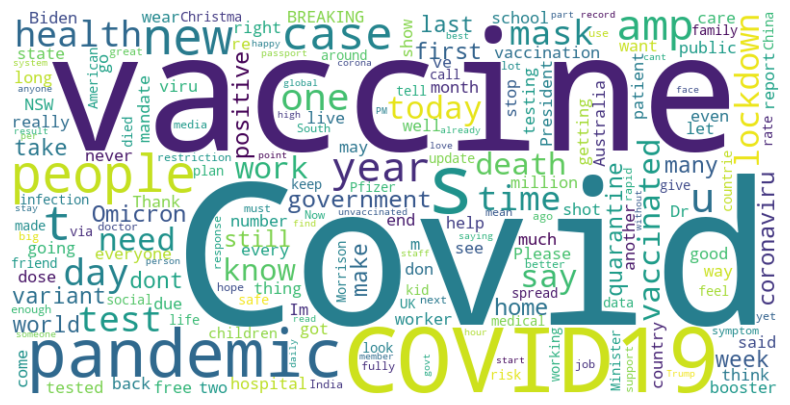

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into a single string
labeled_df['cleaned_text'] = labeled_df['cleaned_text'].astype(str)
text = " ".join(review for review in labeled_df.cleaned_text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [43]:
X = labeled_df['cleaned_text']
y = labeled_df['emotion']

vectorizer = TfidfVectorizer()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text vectorization
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)  # Fit and transform on training data
X_test_vec = vectorizer.transform(X_test)  # Transform the test data

              precision    recall  f1-score   support

       anger       0.95      0.86      0.91      7163
anticipation       0.95      0.94      0.94     12414
     anxiety       0.98      0.96      0.97     97162
     disgust       0.95      0.72      0.82      1855
        fear       0.95      0.94      0.94      5453
         joy       0.95      0.94      0.94     20235
     neutral       0.94      1.00      0.97     72350
       trust       0.96      0.95      0.95     40430
     worried       0.97      0.96      0.96     40257

    accuracy                           0.96    297319
   macro avg       0.96      0.92      0.93    297319
weighted avg       0.96      0.96      0.96    297319



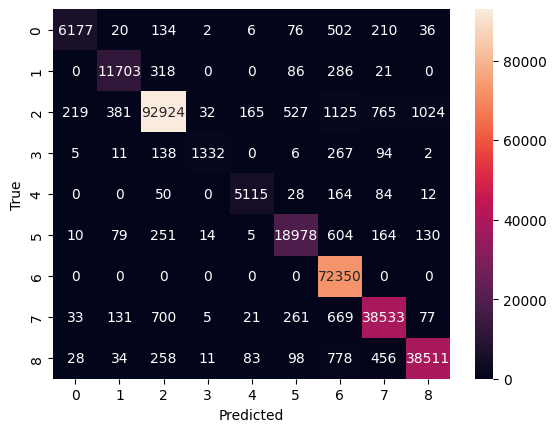

In [47]:
# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Predict
y_pred = model.predict(X_test_vec)

# Evaluation
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()